Examine firing rate changes from MAZE to reMAZE to assess the underlying mechanism for reduced place field specficity and reliability during reMAZE in the SD group

### Imports

In [21]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sstats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from stats_utils import bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

In [16]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])


### Load in firing rate data

In [8]:
fr_df = pd.read_csv(group_data_dir / "remaze_fr.csv", index_col=0)
fr_df

,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0,0_2
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
...,...,...,...,...,...,...,...,...,...
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46
2044,pyr,47,98,0.025219,reMAZE,NaN,SD,8,8_47


### Load in place field data

In [9]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = subjects.Group.basedir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df["cell_id_unique"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}", axis=1)
stats_all_df["cell_id_unique_by_dir"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}_{row.direction}", axis=1)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid,cell_id_unique,cell_id_unique_by_dir
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down


### Plot mean FR for reMAZE vs MAZE

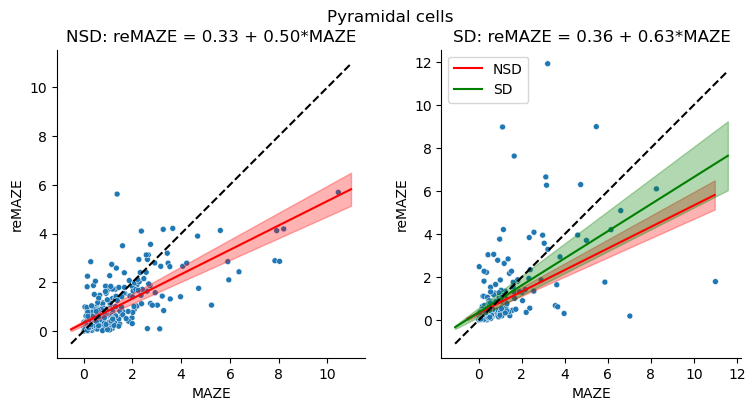

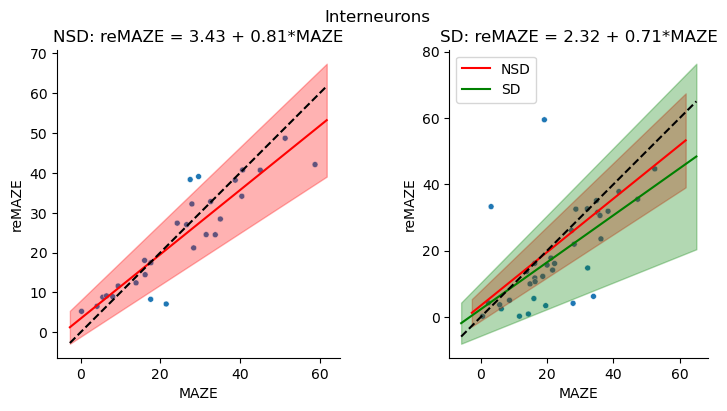

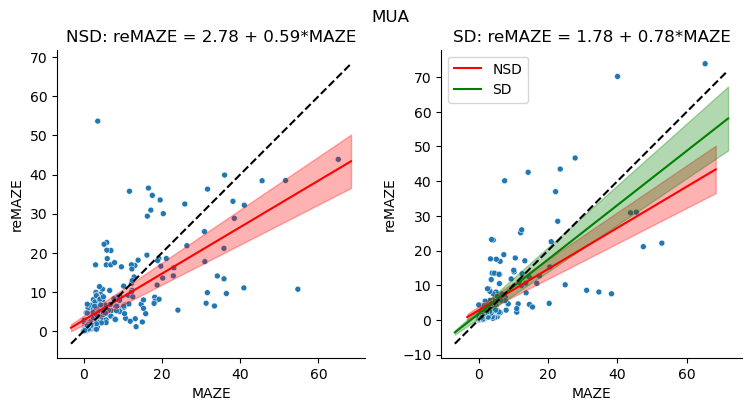

In [11]:
for ntype, nname in zip(["pyr", "inter", "mua"], ["Pyramidal cells", "Interneurons", "MUA"]):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(nname)
    df_type = fr_df[fr_df.neuron_type == ntype]

    xlims_agg = []
    colors = ["r", "g"]
    for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
        df_use = df_type[df_type.grp == grp]
        df_rs = df_use.pivot(columns="session_type", values="mean_frate", index="nid_unique")
        sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, legend=False, ax=a)
        stats = pg.linear_regression(df_rs.MAZE, df_rs.reMAZE)
        if ida == 1:
            a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
        intercept = stats[stats.names == "Intercept"].coef.values[0]
        slope = stats[stats.names == "MAZE"].coef.values[0]
        a.set_aspect('equal')
        xlims = np.array(a.get_xlim())
        # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
        a.plot(xlims, xlims * slope + intercept, color, label="SD")
        intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
        intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
        mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
        mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
        a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
        a.plot(xlims, xlims, 'k--')
        # a.set_xlim(xlims)
        # a.set_ylim(xlims)
        a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        if ida == 1:
            a.legend()
    sns.despine(fig=fig)

### Plot Peak FR for reMAZE vs. MAZE

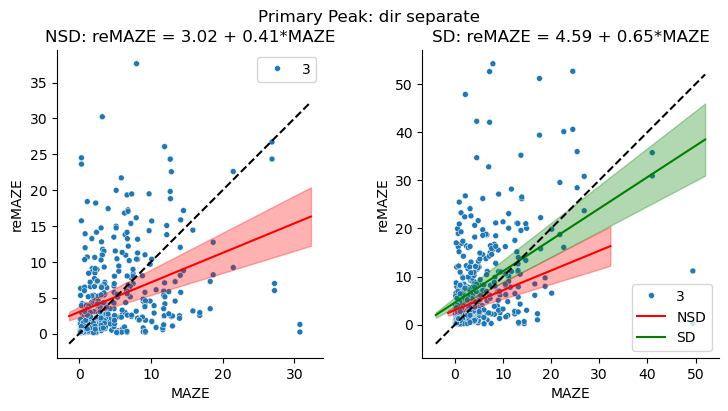

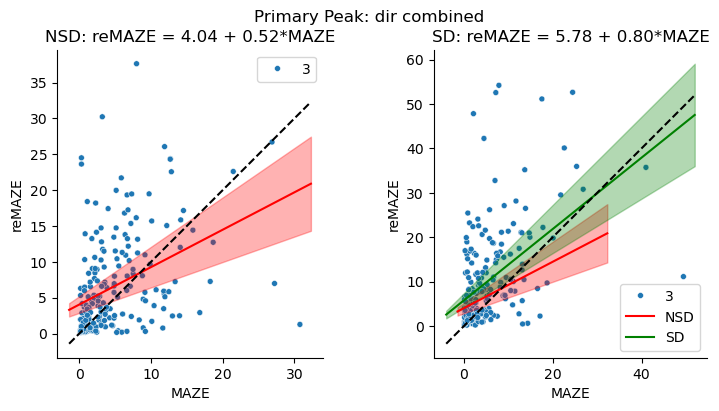

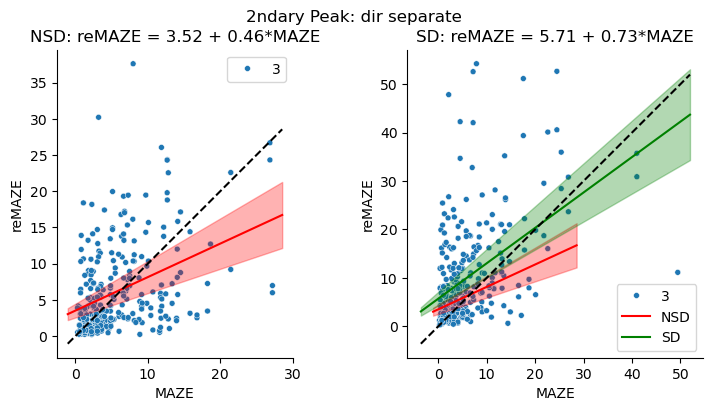

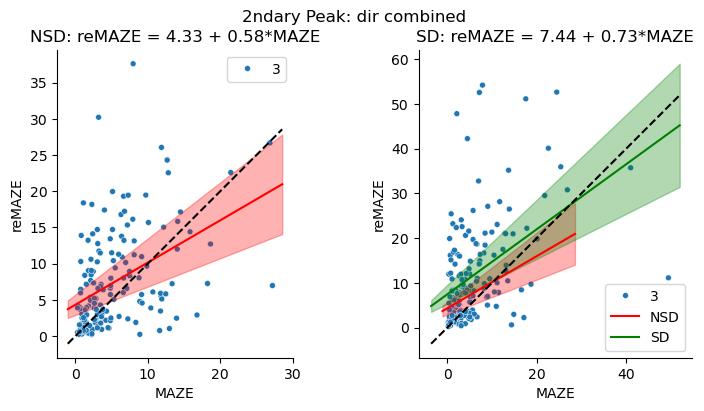

In [12]:
# direction = "separate" # "combined"
for peak in [0, 1]:
    assert peak in [0, 1]
    peak_type = "Primary" if peak == 0 else "2ndary"
    for direction in ["separate", "combined"]:
        assert direction in ["combined", "separate"]
        index_use = "cell_id_unique" if direction == "combined" else "cell_id_unique_by_dir"
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        fig.suptitle(f"{peak_type} Peak: dir {direction}")
        for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
            df_peak = stats_all_df[stats_all_df.peak_no == peak]
            df_use = df_peak[df_peak.grp == grp]
            if direction == "combined":
                df_use = df_use.groupby(["cell_id_unique", "session"]).max().reset_index()
            df_rs = df_use.pivot(columns="session", values="FRmax", index=index_use)
            sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, ax=a)
            df_rs_clean = df_rs[~np.any(np.isnan(df_rs.values), axis=1)]
            stats = pg.linear_regression(df_rs_clean.MAZE, df_rs_clean.reMAZE)
            if ida == 1:
                a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
                a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
            intercept = stats[stats.names == "Intercept"].coef.values[0]
            slope = stats[stats.names == "MAZE"].coef.values[0]
            a.set_aspect('equal')
            xlims = np.array(a.get_xlim())
            # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
            a.plot(xlims, xlims * slope + intercept, color, label="SD")
            intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
            intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
            mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
            mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
            # a.set_xlim(xlims)
            # a.set_ylim(xlims)
            a.plot(xlims, xlims, 'k--')
            if ida == 1:
                a.legend()
            a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        sns.despine(fig=fig)

### Plot mean firing rate changes

In [14]:
df_bs = pd.read_csv(group_data_dir / "remaze_fr_bootstrap.csv", index_col=0)
df_bs

,grp,session,mean_frate,neuron_type
0,NSD,MAZE,1.091980,pyr
1,NSD,MAZE,1.304717,pyr
2,NSD,MAZE,1.095490,pyr
3,NSD,MAZE,1.062064,pyr
4,NSD,MAZE,0.940262,pyr
...,...,...,...,...
19995,SD,reMAZE,8.871773,mua
19996,SD,reMAZE,5.697908,mua
19997,SD,reMAZE,8.239004,mua
19998,SD,reMAZE,7.535709,mua


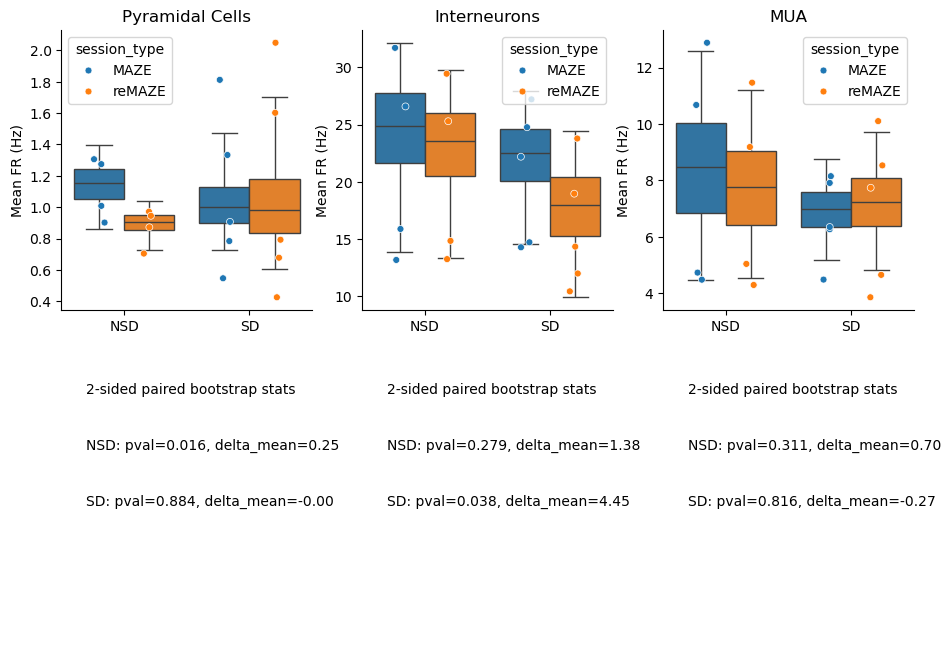

In [31]:
_, axs = plt.subplots(2, 3, figsize=(11, 8))
for ax, axstat, ntype, nname in zip(axs[0], axs[1], ["pyr", "inter", "mua"], ["Pyramidal Cells", "Interneurons", "MUA"]):
    df2 = df_bs[df_bs.neuron_type == ntype]
    df2_mean = fr_df[fr_df.neuron_type == ntype].groupby(["grp", "session_type", "session"]).mean(numeric_only=True)
    sns.boxplot(data=df2, x="grp", y="mean_frate", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, ax=ax)
    sns.stripplot(data=df2_mean, x="grp", y="mean_frate", hue="session_type", dodge=True, edgecolor="w", linewidth=0.5, ax=ax)
    ax.set_title(nname)
    ax.set_ylabel("Mean FR (Hz)")
    ax.set_xlabel("")

    axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
    sns.despine(ax=ax)
    yt = 0.7
    for grp in ["NSD", "SD"]:
        df_grp = df2[df2.grp == grp]
        dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"].mean_frate, df_grp[df_grp.session == "reMAZE"].mean_frate)
        axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
        yt -= 0.2
    sns.despine(ax=axstat, left=True, bottom=True)
    axstat.set_xticks([])
    axstat.set_yticks([])

In [32]:
df_bs = pd.read_csv(group_data_dir / "remaze_fr_delta_bootstrap.csv", index_col=0)

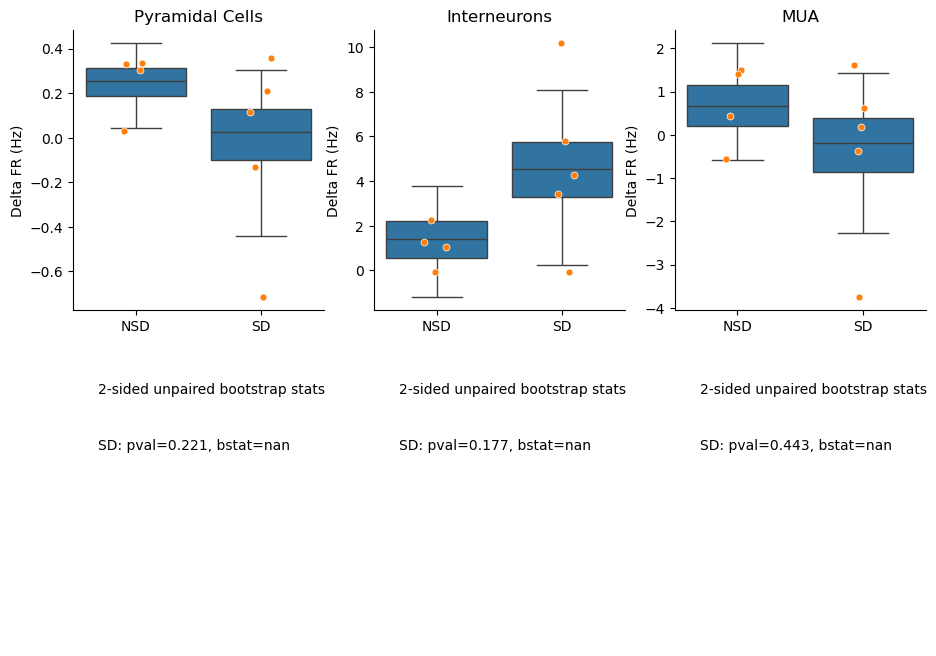

In [37]:
_, axs = plt.subplots(2, 3, figsize=(11, 8))
for ax, axstat, ntype, nname in zip(axs[0], axs[1], ["pyr", "inter", "mua"], ["Pyramidal Cells", "Interneurons", "MUA"]):
    df2 = df_bs[df_bs.neuron_type == ntype]
    df2_mean = fr_df[fr_df.neuron_type == ntype].groupby(["grp", "session_type", "session"]).mean(numeric_only=True)
    sns.boxplot(data=df2, x="grp", y="delta_frate", whis=(2.5, 97.5), showfliers=False, legend=False, ax=ax)
    sns.stripplot(data=df2_mean, x="grp", y="delta_frate_maze_remaze", edgecolor="w", linewidth=0.5, ax=ax)
    ax.set_title(nname)
    ax.set_ylabel("Delta FR (Hz)")
    ax.set_xlabel("")
    sns.despine(ax=ax)

    axstat.text(0.1, 0.9, "2-sided unpaired bootstrap stats") 
    yt = 0.7
    bstat, pval = get_bootstrap_prob(df2[df2.grp == "NSD"].delta_frate, df2[df2.grp == "SD"].delta_frate)
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, bstat={dmean:0.2f}")
    
    sns.despine(ax=axstat, left=True, bottom=True)
    axstat.set_xticks([])
    axstat.set_yticks([])

### Plot max firing rates using time based (not place field based) analysis